Homework 4: Stereo 3D Reconstruction

In this homework, we take two images for a stereophoto in order to do 3D reconstruction.

In [2]:
# Project imports

import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D  
from scipy.linalg import svd
# K from last HW:

K = np.array([
    [1.50518378e+04,   0.0, 2.02730379e+03],
    [  0.0 ,1.48409101e+04, 1.47855129e+03],
    [  0.0 ,   0.0,   1.0]
], dtype=float)


Left: (4080, 3072, 3) Right: (4080, 3072, 3)


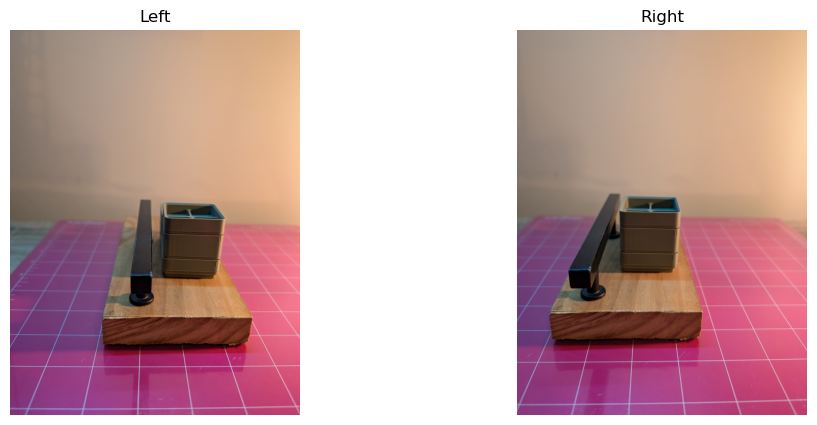

In [3]:
# Section 1: File setup

# load in images
left_img_path  = "/Users/ainee_f/Documents/school_docs/computer_vision/homework04/images/old/PXL_20251029_011833481.jpg"  
right_img_path = "/Users/ainee_f/Documents/school_docs/computer_vision/homework04/images/old/PXL_20251029_011836040.jpg" 

# load in K matrix from the camera calibration homework
# I used the same camera (Google Pixel 10 Pro)

# optional parameters:
sgbm_num_disparities = 128   # multiple of 16
sgbm_block_size      = 7     # odd

# display images (for homework presentation)

def show_side_by_side(imgL, imgR, titleL="Left", titleR="Right"):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(imgL[..., ::-1]); plt.title(titleL); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(imgR[..., ::-1]); plt.title(titleR); plt.axis("off")
    plt.show()

imgL = cv2.imread(left_img_path, cv2.IMREAD_COLOR)
imgR = cv2.imread(right_img_path, cv2.IMREAD_COLOR)
assert imgL is not None and imgR is not None, "Could not load images. Check your paths."
print("Left:", imgL.shape, "Right:", imgR.shape)
show_side_by_side(imgL, imgR)

Tracked 500 points using Lucas–Kanade Optical Flow
SIFT: Raw L=3421, R=2381, Good=641


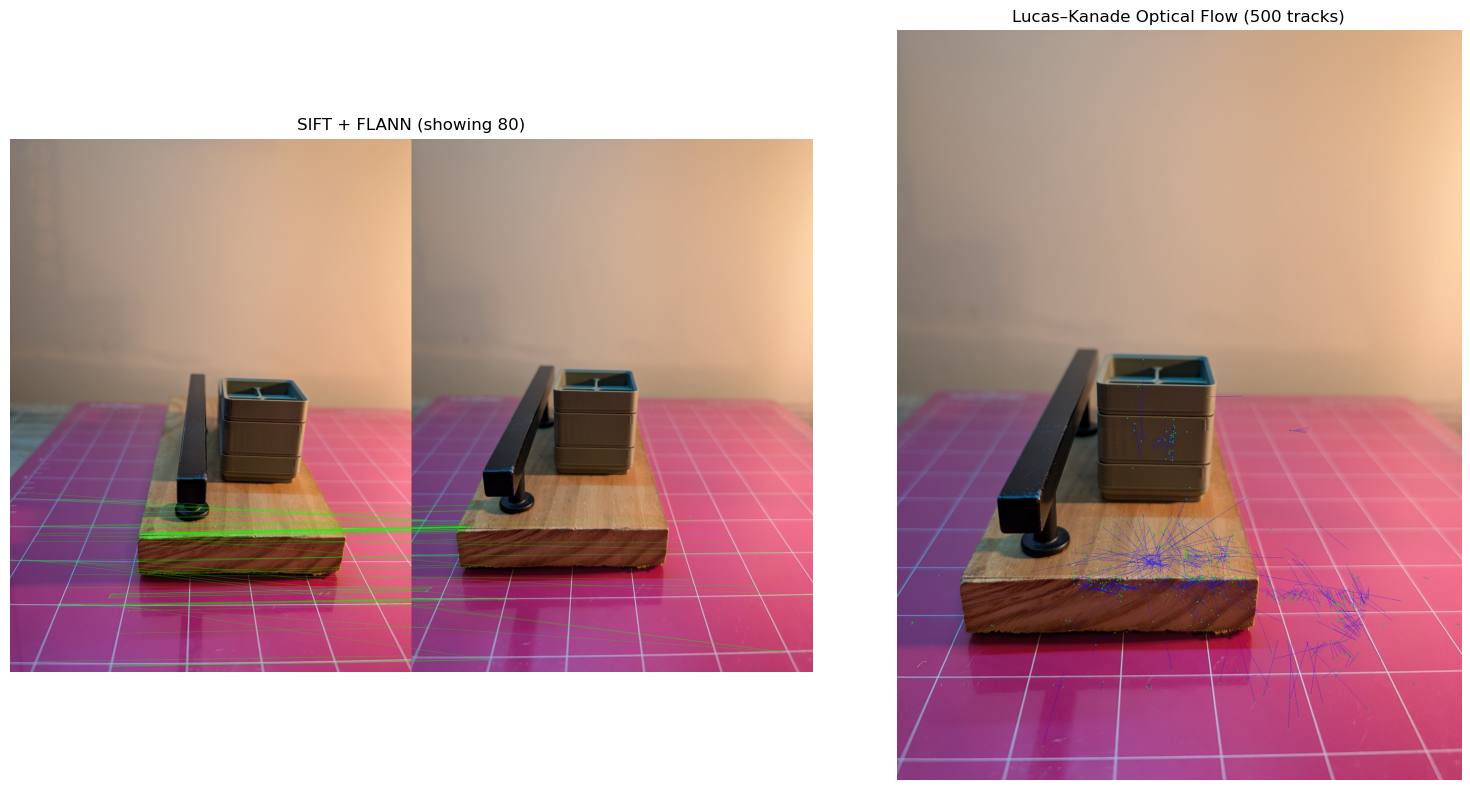

In [4]:
# Section 2: Feature matching

# in this section i follow a lot of the previous methods we've learned to use for feature-matching (from image stitching homework)

# 1) we detect features with SIFT
# 2) match features between the two images with FLANN, and 
# 3) filter to limit to good points using Lowe's ratio test.

def detect_and_match(imgL, imgR, ratio=0.75, max_features=5000):

    # Convert to gray before detecting features
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    # Detect + describe using SIFT
    sift = cv2.SIFT_create(nfeatures=max_features)
    k1, d1 = sift.detectAndCompute(grayL, None)
    k2, d2 = sift.detectAndCompute(grayR, None)

    # FLANN parameters for SIFT (float descriptors)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=100)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    knn_matches = flann.knnMatch(d1, d2, k=2)

    # Lowe’s ratio test
    good_matches = [m for m,n in knn_matches if m.distance < ratio * n.distance]

    print(f"SIFT: Raw L={len(k1)}, R={len(k2)}, Good={len(good_matches)}")
    return k1, k2, good_matches


def show_feature_matches_bold(imgL, kp1, imgR, kp2, matches, max_display=80):

    # subset to avoid clutter
    matches_to_show = matches[:max_display] # only 80 matches shown to clean up

    # Draw default match image
    vis = cv2.drawMatches(
        imgL, kp1,
        imgR, kp2,
        matches_to_show, None,
        matchColor=(0,255,0),  # bright green matches
        singlePointColor=(0,0,255),  # bright red keypoints
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Enhance visibility post-drawing
    # Thickness and brightness boost using dilation
    kernel = np.ones((3,3), np.uint8)
    vis = cv2.dilate(vis, kernel, iterations=1)

    plt.figure(figsize=(14,7))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f"Good Matches (showing {len(matches_to_show)})")
    plt.axis("off")
    plt.show()

# Section 2B: Lucas-Kanade Method

# As an alternative to SIFT + FLANN, we can track points between
# the left and right images using the Lucas–Kanade optical flow method 

# this examines areas or patches of the scene for changes and assumes that the camera displacement is relatively small
# the images will have similar brightness and the movement is constant

# grayscale to see intensity patterns
grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

# this section "goodFeatures" looks for CORNERS and the LK algorithm will try to track the movement of
# corners
# Looks for up to 500 points, and the min distance tries to avoid corners too close to each others
p0 = cv2.goodFeaturesToTrack(grayL, maxCorners=500, qualityLevel=0.01, minDistance=8)


# this section tracks every left image point into the right side of the image using cv2's optical flow module
# it uses "windows" - in this case 15x15 windows to search for motion
# the criteria for "stopping" is the number of iterations (10)
# it gives us (output) tracked points
lk_params = dict(winSize=(15,15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

p1, st, err = cv2.calcOpticalFlowPyrLK(grayL, grayR, p0, None, **lk_params)
st = st.reshape(-1)
good_old = p0[st==1]
good_new = p1[st==1]

print(f"Tracked {len(good_new)} points using Lucas–Kanade Optical Flow")

### VISUALIZATION

vis = imgR.copy()
for (x1, y1), (x2, y2) in zip(good_old.reshape(-1,2), good_new.reshape(-1,2)):
    cv2.circle(vis, (int(x2), int(y2)), 3, (0,255,0), -1)
    cv2.line(vis, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 1)

def side_by_side_sift_lk(imgL, imgR, kps1, kps2, good_matches, pts1_lk, pts2_lk,
                         max_sift_display=80):

    # SIFT image
    sift_subset = good_matches[:max_sift_display]
    sift_vis = cv2.drawMatches(
        imgL, kps1,
        imgR, kps2,
        sift_subset, None,
        matchColor=(0,255,0),
        singlePointColor=(0,0,255),
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # LK Method image
    lk_vis = imgR.copy()
    for (x1, y1), (x2, y2) in zip(pts1_lk, pts2_lk):
        cv2.circle(lk_vis, (int(x2), int(y2)), 3, (0,255,0), -1)
        cv2.line(lk_vis, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 1)

    # side by side comparison
    plt.figure(figsize=(16,8))

    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(sift_vis, cv2.COLOR_BGR2RGB))
    plt.title(f"SIFT + FLANN (showing {len(sift_subset)})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(lk_vis, cv2.COLOR_BGR2RGB))
    plt.title(f"Lucas–Kanade Optical Flow ({len(pts1_lk)} tracks)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Save these points for later F estimation
pts1_lk = good_old.reshape(-1,2)
pts2_lk = good_new.reshape(-1,2)

# Run matching + visualization
kps1, kps2, good_matches = detect_and_match(imgL, imgR)

# Extract matched pixel coordinates
pts1 = np.float32([kps1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kps2[m.trainIdx].pt for m in good_matches])

side_by_side_sift_lk(
    imgL, imgR,
    kps1, kps2,
    good_matches,
    pts1_lk, pts2_lk
)

In [5]:
# Section 3: in this section, we use the matches detected in the previous section to estimate the fundamental matrix
# we will use points gathered both from SIFT and the LK method in order to compare their outputs. 



# first, we normalize the points because raw pixel coordinates can be very large and makes
# the A matrix badly conditioned

# translate points so that their centroid is 0
# scale so their average distance is sqrt(2)
# use this for 8-point stability
def normalize_points(xy):
    """
    Normalize 2D points so that:
    - centroid is at origin
    - average distance from origin = sqrt(2)
    Returns normalized points and the normalization matrix T.
    """
    mean = np.mean(xy, axis=0)
    d = xy - mean
    mean_dist = np.mean(np.sqrt(np.sum(d**2, axis=1))) + 1e-12
    s = np.sqrt(2.0) / mean_dist

    T = np.array([
        [s, 0, -s*mean[0]],
        [0, s, -s*mean[1]],
        [0, 0, 1]
    ], dtype=float)

    xy_h = np.hstack([xy, np.ones((xy.shape[0], 1))])   # homogenize
    xy_norm_h = (T @ xy_h.T).T                          # apply transform
    xy_norm = xy_norm_h[:, :2]                          # drop homogeneous coord

    return xy_norm, T


def eight_point_F(xy1, xy2):
    """
    Compute the Fundamental Matrix using:
    - normalized 8-point algorithm
    - rank-2 enforcement
    - denormalization
    Matches exactly the method shown in the slides.
    """
    # Step 1: Normalize both sets of points
    x1_norm, T1 = normalize_points(xy1)
    x2_norm, T2 = normalize_points(xy2)

    # Convert to homogeneous
    x1 = np.hstack([x1_norm, np.ones((x1_norm.shape[0], 1))])
    x2 = np.hstack([x2_norm, np.ones((x2_norm.shape[0], 1))])

    # Step 2: Build matrix A (size N x 9)
    A = np.stack([
        x2[:,0] * x1[:,0],     # x2*x1
        x2[:,0] * x1[:,1],     # x2*y1
        x2[:,0],               # x2
        x2[:,1] * x1[:,0],     # y2*x1
        x2[:,1] * x1[:,1],     # y2*y1
        x2[:,1],               # y2
        x1[:,0],               # x1
        x1[:,1],               # y1
        np.ones(x1.shape[0])   # 1
    ], axis=1)

    # Step 3: Solve Af = 0 using SVD
    # _, _, VT = np.linalg.svd(A)
    _, _, VT = svd(A)
    f = VT[-1]                  # solution is last row of V^T
    F = f.reshape(3, 3)

    # Step 4: Enforce rank-2 constraint on F
    U, S, VT = svd(F)
    S[-1] = 0.0                 # zero the smallest singular value
    F_rank2 = U @ np.diag(S) @ VT

    # Step 5: De-normalize: F = T2^T F T1
    F_denorm = T2.T @ F_rank2 @ T1

    # Scale so (3,3) entry becomes 1 (optional but common)
    return F_denorm / (F_denorm[2,2] + 1e-12)

# Implementation

print("SIFT + RANSAC Inlier Detection")

# before we run the 8-point algorithm, we first remove all the mismatches using
# RANSAC to do a final clean-up of the matched points and find INLIERS
F_ransac, mask_sift = cv2.findFundamentalMat(
    pts1, pts2,
    method=cv2.FM_RANSAC,
    ransacReprojThreshold=1.0,
    confidence=0.999
)

mask_sift = mask_sift.ravel()
inliers1 = pts1[mask_sift == 1]
inliers2 = pts2[mask_sift == 1]

print(f"SIFT inliers: {len(inliers1)} / {len(pts1)}")

# here we ompute F using our normalized 8-point method defined ABOVE
# we do this by normalizing the points and then manually building the matrix with 
# each correspondence (x, y) -> (x', y') contributing to one row of the A matrix
# it will loop and stack each match to grow the A matrix

F_final_sift = eight_point_F(inliers1, inliers2)
print("\nF (8-point, SIFT inliers):\n", F_final_sift)


print("\nLK + RANSAC Inlier Detection")

# REPEAT the steps using LK Inliers 
F_ransac_lk, mask_lk = cv2.findFundamentalMat(
    pts1_lk, pts2_lk,
    method=cv2.FM_RANSAC,
    ransacReprojThreshold=1.0,
    confidence=0.999
)

mask_lk = mask_lk.ravel()
inliers1_lk = pts1_lk[mask_lk == 1]
inliers2_lk = pts2_lk[mask_lk == 1]

print(f"LK inliers: {len(inliers1_lk)} / {len(pts1_lk)}")

# Step 2: Eight-point algorithm on LK inliers
F_final_lk = eight_point_F(inliers1_lk, inliers2_lk)
print("\nF (8-point, LK inliers):\n", F_final_lk)


SIFT + RANSAC Inlier Detection
SIFT inliers: 413 / 641

F (8-point, SIFT inliers):
 [[ 4.52645986e-10 -8.61755135e-08  1.69967347e-04]
 [ 9.48537172e-08  1.22314221e-07 -4.72238853e-03]
 [-2.07089210e-04  3.92895344e-03  1.00000000e+00]]

LK + RANSAC Inlier Detection
LK inliers: 19 / 500

F (8-point, LK inliers):
 [[ 7.63849524e-08 -1.58326687e-06  4.62348137e-03]
 [ 1.55326797e-06  6.58953496e-08 -3.78324467e-03]
 [-4.76187443e-03  3.29403263e-03  1.00000000e+00]]


Best Epipolar Correspondence (SIFT + FLANN)
Index         : 368
Residual      : 6.148894e-07
Left point    : [2442.2231 3039.0598]
Right point   : [1834.4528 2978.373 ]


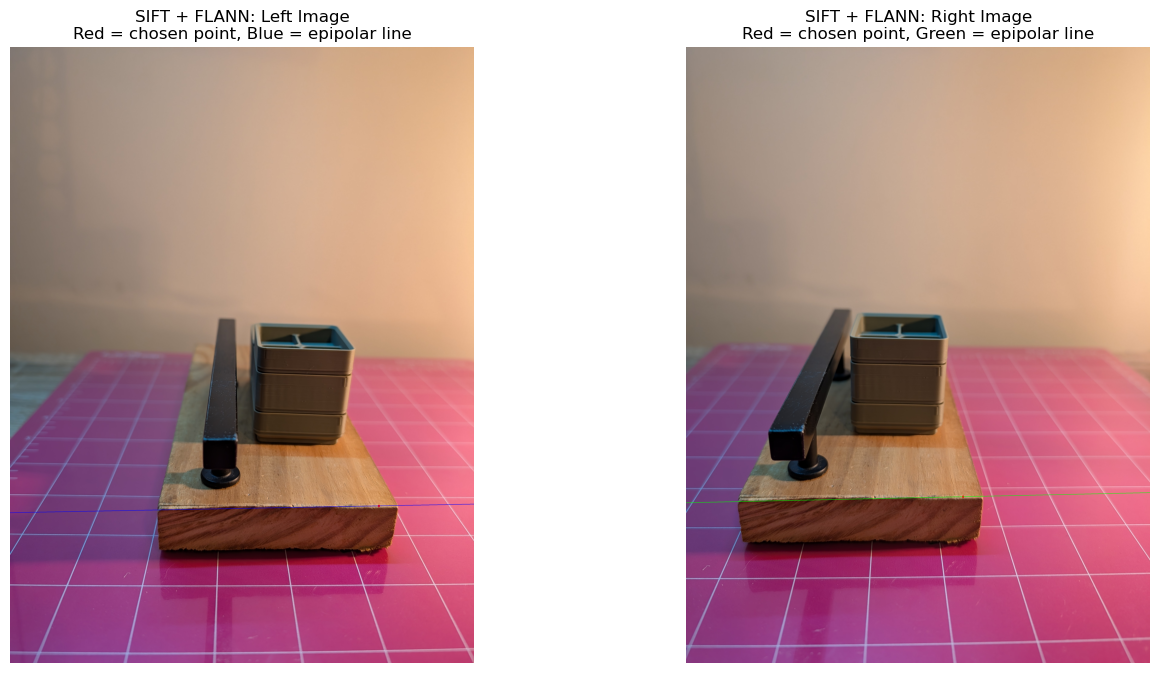

In [6]:
# Section 4: in this section, we pick a SINGLE best pair of matches that
# satisfies the epipolar constraint and visualize it. We use this best match later on for 3D reocnsutrction. 

# We use it later to estimate the essential matrix, pose extraction, and triangulation of a 3D point

# finds the matched pair that best satisfies the epipolar constraint
def pick_best_epipolar_pair(ptsL, ptsR, F):
    """Returns best match based on minimal |xR^T F xL| residual."""
    ptsL_h = np.hstack([ptsL, np.ones((ptsL.shape[0],1))])
    ptsR_h = np.hstack([ptsR, np.ones((ptsR.shape[0],1))])

    residuals = np.abs(np.sum(ptsR_h * (F @ ptsL_h.T).T, axis=1))
    best_idx = np.argmin(residuals)
    return best_idx, residuals[best_idx], ptsL[best_idx], ptsR[best_idx]


# this is mostly for visualization
def draw_epipolar_line(img, line, color, thickness=5):
    """Draw epipolar line ax + by + c = 0 across the image."""
    a, b, c = line
    h, w = img.shape[:2]

    pts = []
    # intersections with x=0 and x=w
    if abs(b) > 1e-6:
        pts.append((0, int(-c/b)))
        pts.append((w, int(-(a*w + c) / b)))
    # intersections with y=0 and y=h
    if abs(a) > 1e-6:
        pts.append((int(-c/a), 0))
        pts.append((int(-(b*h + c) / a), h))

    # keep only visible points
    pts = [(x,y) for (x,y) in pts if 0 <= x <= w and 0 <= y <= h]
    if len(pts) >= 2:
        cv2.line(img, pts[0], pts[1], color, thickness)


# section to switch between LK or SIFT / FLANN method
use_lk = False   # <--- switch this between SIFT and LK

if use_lk:
    ptsL = inliers1_lk
    ptsR = inliers2_lk
    F_used = F_final_lk        # use your 8-point F
    method_name = "LK Optical Flow"
else:
    ptsL = inliers1
    ptsR = inliers2
    F_used = F_final_sift      # use your 8-point F
    method_name = "SIFT + FLANN"


# in this section, runs the scripts to generate the best correspondences
best_idx, best_res, best_L, best_R = pick_best_epipolar_pair(ptsL, ptsR, F_used)

print(f"Best Epipolar Correspondence ({method_name})")
print(f"Index         : {best_idx}")
print(f"Residual      : {best_res:.6e}")
print(f"Left point    : {best_L}")
print(f"Right point   : {best_R}")

# Save them for triangulation later
xL_best = best_L.copy()
xR_best = best_R.copy()
F_best  = F_used.copy()

# show the epipolar line on the RIGHT image for visualization
L_vis = imgL.copy()
R_vis = imgR.copy()

cv2.circle(L_vis, tuple(xL_best.astype(int)), 8, (0,0,255), -1)
cv2.circle(R_vis, tuple(xR_best.astype(int)), 8, (0,0,255), -1)

# Compute epipolar lines
xL_h = np.array([xL_best[0], xL_best[1], 1.0])
xR_h = np.array([xR_best[0], xR_best[1], 1.0])

lineR = F_best @ xL_h      # epipolar line in right image
lineL = F_best.T @ xR_h    # epipolar line in left image

draw_epipolar_line(R_vis, lineR, (0,255,0), thickness=2)
draw_epipolar_line(L_vis, lineL, (255,0,0), thickness=2)


# visualize / display results

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(L_vis, cv2.COLOR_BGR2RGB))
plt.title(f"{method_name}: Left Image\nRed = chosen point, Blue = epipolar line")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(R_vis, cv2.COLOR_BGR2RGB))
plt.title(f"{method_name}: Right Image\nRed = chosen point, Green = epipolar line")
plt.axis("off")

plt.show()

In [7]:
# Section 5: In this section, we use the camera instrinsics K and the previously generated F matrix to compute the essential matrix E

# The E matrix allows us to extract the pose (R and t) of the camera relative to the left image. E = K^(T)FK

# K value from previous HW (I used the same camera)
K = np.array([
    [1.50518378e+04,   0.0, 2.02730379e+03],
    [  0.0 ,1.48409101e+04, 1.47855129e+03],
    [  0.0 ,   0.0,   1.0]
], dtype=float)

print("Using camera intrinsics K =\n", K)

# Compute Essential Matrix
E = K.T @ F_best @ K # based on the algorithm shown above

print("\nEssential Matrix E (from 8-point F):\n", E)

Using camera intrinsics K =
 [[1.50518378e+04 0.00000000e+00 2.02730379e+03]
 [0.00000000e+00 1.48409101e+04 1.47855129e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Essential Matrix E (from 8-point F):
 [[ 1.02550488e-01 -1.92501423e+01  6.54304618e-01]
 [ 2.11887052e+01  2.69400267e+01 -6.45467300e+01]
 [-9.92299536e-01  5.84004259e+01  4.68740856e-02]]


In [8]:

# Section 6: Decompose E into R, t and pick the valid pose

# here we ensure that E satisfies rank = 2 with two equal singular values, and a third value = 0
U, S, VT = svd(E)

# Average the first two singular values, set the third to zero (enforcing the constraint)
sigma = (S[0] + S[1]) / 2.0
E_fixed = U @ np.diag([sigma, sigma, 0.0]) @ VT

print("Fixed Essential Matrix E (rank-2 enforced):\n", E_fixed)

# 2) Decompose E into rotation(s) and translation direction(s)
U, _, VT = svd(E_fixed)

# Ensure we have a proper rotation (det(R) = +1) by fixing U or V if needed
if np.linalg.det(U) < 0:
    U[:, -1] *= -1
if np.linalg.det(VT) < 0:
    VT[-1, :] *= -1

W = np.array([[0, -1, 0],
              [1,  0, 0],
              [0,  0, 1]])

R1 = U @ W  @ VT
R2 = U @ W.T @ VT
t  = U[:, 2]    # translation direction (up to scale)

# Make sure rotations are proper (det = +1)
if np.linalg.det(R1) < 0:
    R1 *= -1
if np.linalg.det(R2) < 0:
    R2 *= -1

# 4 candidate poses: (R1, +t), (R1, -t), (R2, +t), (R2, -t)
# there are several possible rotation and translation poses
# but we can check which one is true by seeing which has a positive depth value and picking 
# that one

candidates = [
    (R1,  t),
    (R1, -t),
    (R2,  t),
    (R2, -t)
]

print("\nCandidate camera poses (R, t) generated.")


# this section triangluates the chose correspondence under each pose based on
# camera 1 projection matrix and right camera projection matrix 

# the two possible R matrices we get (R1, R2) and the t matrix between the two images
# help us triangulate a single point

def triangulate_point(P1, P2, xL, xR):
    """
    Triangulate a single point given two projection matrices.
    xL and xR are 2-element arrays: [u, v]
    """
    # Convert to 2x1 arrays as required by OpenCV
    xL_2x1 = np.array([[xL[0]], [xL[1]]], dtype=float)
    xR_2x1 = np.array([[xR[0]], [xR[1]]], dtype=float)

    # Perform triangulation
    X_h = cv2.triangulatePoints(P1, P2, xL_2x1, xR_2x1)  # 4×1 vector
    X   = (X_h[:3] / X_h[3]).flatten()                   # convert to 3D Cartesian

    return X


def depth_in_camera(R, t, X):
    """Compute depth (Z) of 3D point X in camera 2's coordinate frame."""
    X_cam2 = R @ X + t
    return X_cam2[2]


# Camera 1 projection matrix: P1 = K [I | 0]
P1 = K @ np.hstack([np.eye(3), np.zeros((3,1))])

best_pose = None
best_X    = None

print("\nChecking candidate poses using cheirality (positive depth)")
for i, (R, t_vec) in enumerate(candidates):
    P2 = K @ np.hstack([R, t_vec.reshape(3,1)])

    # Triangulate the single chosen match
    X = triangulate_point(P1, P2, xL_best, xR_best)

    z1 = X[2]                # depth in camera 1
    z2 = depth_in_camera(R, t_vec, X)  # depth in camera 2

    print(f"Pose {i}: Z1 = {z1:.4f}, Z2 = {z2:.4f}")

    if z1 > 0 and z2 > 0 and best_pose is None:
        best_pose = (R, t_vec)
        best_X    = X

if best_pose is None:
    print("\nWARNING: No pose yielded positive depth for this single point.")
    print("You may need to test more points or verify correspondences.")
else:
    R_best, t_best = best_pose
    print("\n=== Selected camera pose (R_best, t_best) ===")
    print("R_best =\n", R_best)
    print("t_best =\n", t_best)
    print("\nTriangulated 3D point X_best =\n", best_X)

Fixed Essential Matrix E (rank-2 enforced):
 [[  1.44034389 -20.11905505  -3.29280555]
 [ 20.36666702  13.55033018 -61.42682544]
 [ -5.08438572  61.5028969   12.09824636]]

Candidate camera poses (R, t) generated.

Checking candidate poses using cheirality (positive depth)
Pose 0: Z1 = 16.0396, Z2 = 15.4089
Pose 1: Z1 = -16.0396, Z2 = -15.4089
Pose 2: Z1 = 1.5286, Z2 = -1.4706
Pose 3: Z1 = -1.5286, Z2 = 1.4706

=== Selected camera pose (R_best, t_best) ===
R_best =
 [[ 9.97511316e-01  6.92102977e-02  1.34576857e-02]
 [-7.05063907e-02  9.78754955e-01  1.92529445e-01]
 [ 1.53243629e-04 -1.92999153e-01  9.81198911e-01]]
t_best =
 [-0.95103297 -0.00986489 -0.30893199]

Triangulated 3D point X_best =
 [ 0.54651898  0.10505098 16.03960375]


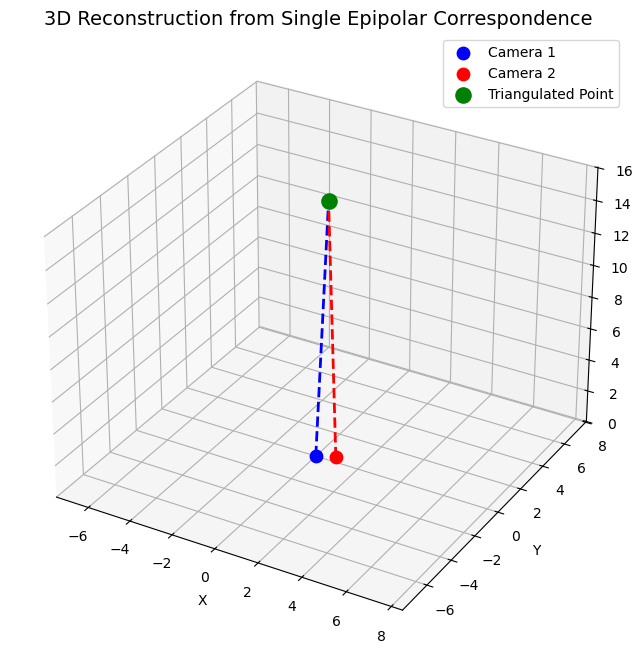

In [9]:
# section 7: 3D visualization of reconstructed point

from mpl_toolkits.mplot3d import Axes3D

if best_X is None:
    print("Cannot visualize: no valid pose was found earlier.")
else:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Camera 1 at origin
    C1 = np.array([0, 0, 0])

    # Camera 2 center:
    # If P2 = K [R | t], the camera center is:  C2 = -R^T t
    C2 = -R_best.T @ t_best

    Xp = best_X  # triangulated point in world frame

    # --- Plot cameras ---
    ax.scatter(C1[0], C1[1], C1[2], color='blue', s=80, label='Camera 1')
    ax.scatter(C2[0], C2[1], C2[2], color='red',  s=80, label='Camera 2')

    # --- Plot the 3D point ---
    ax.scatter(Xp[0], Xp[1], Xp[2], color='green', s=120, label='Triangulated Point')

    # --- Rays from cameras ---
    ax.plot([C1[0], Xp[0]], [C1[1], Xp[1]], [C1[2], Xp[2]], 'b--', linewidth=2)
    ax.plot([C2[0], Xp[0]], [C2[1], Xp[1]], [C2[2], Xp[2]], 'r--', linewidth=2)

    # --- Labeling and view ---
    ax.set_title("3D Reconstruction from Single Epipolar Correspondence", fontsize=14)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()

    # Equal aspect ratio so geometry isn’t distorted
    vals = np.array([
    Xp[0], Xp[1], Xp[2],
    C1[0], C1[1], C1[2],
    C2[0], C2[1], C2[2]
    ])
    max_range = np.ptp(vals)

    Xmid = (np.array([Xp[0], C1[0], C2[0]]).max() + np.array([Xp[0], C1[0], C2[0]]).min()) / 2
    Ymid = (np.array([Xp[1], C1[1], C2[1]]).max() + np.array([Xp[1], C1[1], C2[1]]).min()) / 2
    Zmid = (np.array([Xp[2], C1[2], C2[2]]).max() + np.array([Xp[2], C1[2], C2[2]]).min()) / 2

    ax.set_xlim(Xmid - max_range/2, Xmid + max_range/2)
    ax.set_ylim(Ymid - max_range/2, Ymid + max_range/2)
    ax.set_zlim(Zmid - max_range/2, Zmid + max_range/2)

    plt.show()

In [10]:
# add: compute z for every point